In [1]:
import os
import glob
import numpy as np
import pandas as pd
import skimage.morphology


In [2]:
params_file = './params.xlsx'

In [3]:
def computeBoundaries(signal, th):
    # Identify locations where the signal is greater than the threshold
    locs = np.where(signal > th)[0]

    # Create an array of zeros and assign 1 to the identified locations
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Perform morphological closing and opening operations on the indexes array
    selem = np.ones((1300, 1)) #70,1
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    # Identify locations where the opened array has 1's
    locsNew = np.where(opened == 1)[0]

    # Compute the difference between adjacent elements of locsNew
    derNew = np.diff(locsNew)

    # Find indices where the difference is greater than 1
    ind = np.where(derNew > 1)[0]

    # Compute starting and ending indices of the sections
    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

In [4]:
def compute_segment_lengths(starting, ending):
    return ending - starting

def compute_statistics(lengths):
    average = np.mean(lengths)
    std_dev = np.std(lengths)
    return average, std_dev

def compute_large_gaps(starting, ending, gap_threshold=1300):
    gaps = starting[1:] - ending[:-1]
    print(gaps)
    large_gaps = np.sum(gaps > gap_threshold)
    return large_gaps


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_with_boundaries(raw_data_list, processed_data, file_number):
    channel_names = ["Trigger (Machine)", "Flat Response Microphone (Front)", 
                     "Flat Response Microphone (Rear)", "Resonant Microphone"]
    
    sampling_freq = 200000  # Sampling frequency in Hz
    fig, axs = plt.subplots(len(raw_data_list), 1, figsize=(10, 12), sharex=True)
    fig.suptitle(f'Signal {file_number}', fontsize=16)
    plt.subplots_adjust(hspace=0.5)

    for j, signal_data in enumerate(raw_data_list):
        channel_index = j + 1  # Adjusting for 0-based index
        starting, ending = processed_data.get(f'Channel_{channel_index}', {}).get('boundaries', ([], []))
        
        # Convert sample indices to time
        time_axis = np.arange(len(signal_data)) / sampling_freq
        
        # Plot using time_axis for the x-axis
        axs[j].plot(time_axis, signal_data, label=f'Channel {channel_index} - {channel_names[channel_index]}')
        
        # Convert starting and ending indices to time
        starting_time = starting / sampling_freq
        ending_time = ending / sampling_freq
        
        # Scatter plot for starting and ending points using converted time
        axs[j].scatter(starting_time, signal_data[starting], color='g', label='Starting', zorder=5)
        axs[j].scatter(ending_time, signal_data[ending], color='r', label='Ending', zorder=5)
        
        axs[j].legend(loc="upper right")
        axs[j].set_title(channel_names[channel_index]+ " " +processed_data.get(f'Channel_{channel_index}', {}).get('Operation', ([])))
        axs[j].set_ylabel('Amplitude (V)')
        axs[j].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()


In [6]:
import os
import pandas as pd
import warnings


def process_file(channels, file_name, threshold, excel_path):
    th = 10000
    # Read the corresponding row from the Excel file based on file_number
    excel_data = pd.read_excel(excel_path)
    
    # Use regular expression to find all numbers in the string
    numbers_in_string = re.findall(r'\d+', file_name)

    # Convert the first found number to integer
    file_number = int(numbers_in_string[0]) if numbers_in_string else None
    row = excel_data.iloc[file_number]
    operation = row['Operation']
    cube_1_mode = row['Cube 1 Mode']
    cube_2_mode = row['Cube 2 Mode']

    file_data = {}
    raw_data_list = []  # To store raw data for each channel
    print(f"\nProcessing File: {file_name}, Operation: {operation}, Cube 1 Mode: {cube_1_mode}, Cube 2 Mode: {cube_2_mode}")

    for channel_index, channel_path in enumerate(channels):
        if channel_index == 0:  # Skip Channel 0
            print("Skipping Channel 0 as per requirements.")
            continue
        
        channel_file_path = os.path.join(channel_path, f"{file_name}.parquet")
        print(f"Reading data from {channel_file_path} for Channel {channel_index}")
        channel_data = pd.read_parquet(channel_file_path)
        signal_data = channel_data.iloc[:, 0].values  # The signal data is in the first column
        raw_data_list.append(signal_data)  # Store raw data

        # Compute boundaries and segments
        if channel_index == 3:  # Use Channel 2's boundaries for Channel 3
            starting, ending = file_data['Channel_2']['boundaries']
            print("Using vecchia ciabatta")
        else:
            starting, ending = computeBoundaries(signal_data, threshold)
        
        segments = [signal_data[start:end+1] for start, end in zip(starting, ending) if end-start+1 >= th]
        starting_pruned = np.array([start for start, end in zip(starting, ending) if end-start+1 >= th])
        ending_pruned = np.array([end for start, end in zip(starting, ending) if end-start+1 >= th])
        
        if len(segments) < len(starting):  # If any segments are excluded
            warnings.warn(f"Warning: Excluded segment smaller than {th} points.")
        
        segment_lengths = [len(segment) for segment in segments]
        avg_length, std_dev = compute_statistics(segment_lengths)
        num_segments = len(segments)

        # Add extracted information and processed data to file_data
        file_data[f'Channel_{channel_index}'] = {
            'Operation': operation,
            'Cube 1 Mode': cube_1_mode,
            'Cube 2 Mode': cube_2_mode,
            'segments': segments,
            'boundaries': (starting_pruned, ending_pruned),
            'avg_length': avg_length,
            'std_dev': std_dev,
            'num_segments': num_segments
        }

        print(f"Channel {channel_index}: Processed with {len(segments)} segments detected.")
        print(f"Average Segment Length: {avg_length:.2f}, Standard Deviation: {std_dev:.2f}, Num. segments: {num_segments}")
        
        # Large gaps validation after excluding small segments
        if (operation == "Sequential" and num_segments != 2) or (operation == "Simultaneous" and num_segments != 1):
            warnings.warn(f"Warning: Expected segment count not met for {operation} operation. Num. segments: {num_segments}")

    return file_data, raw_data_list


In [7]:
import random
import glob
import os
import re

def parse_multimodal_signals_corrected_with_plotting(path, threshold=1.0, N=10):
    channels = glob.glob(os.path.join(path, "*/"))
    channels.sort()
    
    sample_files = glob.glob(os.path.join(channels[0], "*.parquet"))
    sample_files.sort(key=lambda x: int(re.search(r'File_(\d+)', x).group(1)))
    
    selected_files = random.sample(sample_files, min(N, len(sample_files)))
    
    all_processed_data = {}
    problematic_files = []  # List to store file numbers of problematic files

    for sample_file in selected_files:
        file_name = os.path.splitext(os.path.basename(sample_file))[0]
        print(channels)
        processed_data, raw_data_list = process_file(channels, file_name, threshold, params_file)
        
        # Initialize a flag to track if the file is problematic
        is_problematic = False

        # Iterate through processed data to check large gaps for each channel
        for channel_key, channel_info in processed_data.items():
            if channel_key == 'Channel_0':
                continue  # Skip Channel 0 as per original requirement

            # Extract operation type for the current file from the processed_data
            operation_type = channel_info['Operation']
            
            # Determine the expected number of large gaps
            expected_segments = 2 if operation_type == 'Sequential' else 1

            if channel_info['num_segments'] != expected_segments:
                print(f"Warning: File_{file_name} in {channel_key} has {channel_info['num_segments']} segments instead of {expected_segments}.")
                problematic_files.append(file_name)
                is_problematic = True
                break  # Assuming if one channel is problematic, the file is considered problematic

        if not is_problematic:
            all_processed_data[file_name] = processed_data
        
        print(f"Plotting signals processed up to file number: {file_name}")
        plot_signals_with_boundaries(raw_data_list, processed_data, file_name)
        print('----'*32)
        
    if problematic_files:
        print(f"Problematic files (large gaps not as expected): {problematic_files}")
    
    return all_processed_data


['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_291, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_291.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525765.00, Standard Deviation: 144885.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_291.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 524678.00, Standard Deviation: 144691.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_291.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524678.00, Standard Deviation: 144691.00, Num. segments: 2
Plotting signals processed up to file number: File_291


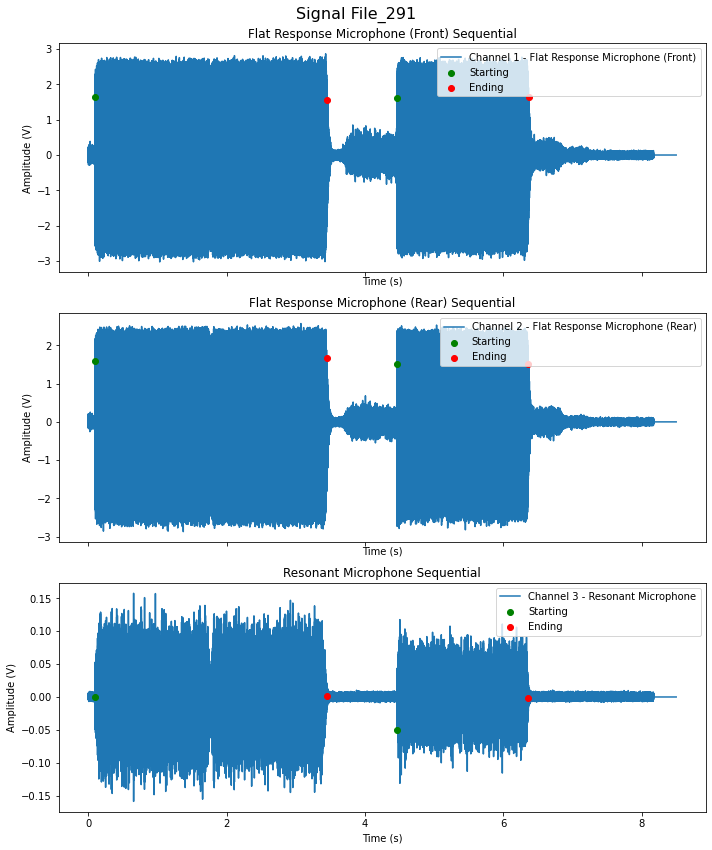

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_228, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_228.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549657.50, Standard Deviation: 121482.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_228.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 547868.50, Standard Deviation: 122042.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_228.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547868.50, Standard Deviation: 122042.50, Num. segments: 2
Plotting

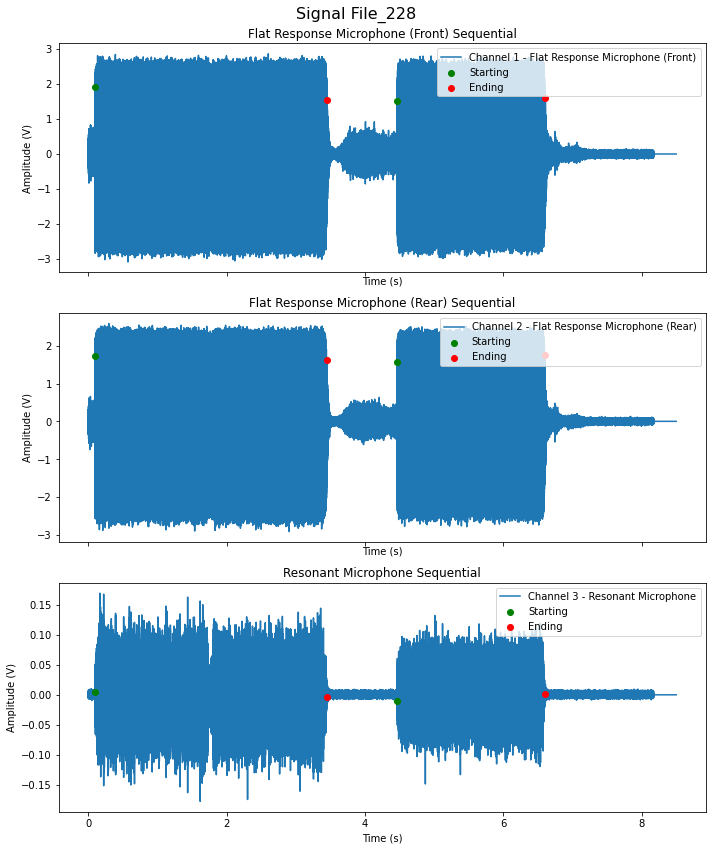

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_278, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_278.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672627.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_278.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670667.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_278.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670667.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals proc

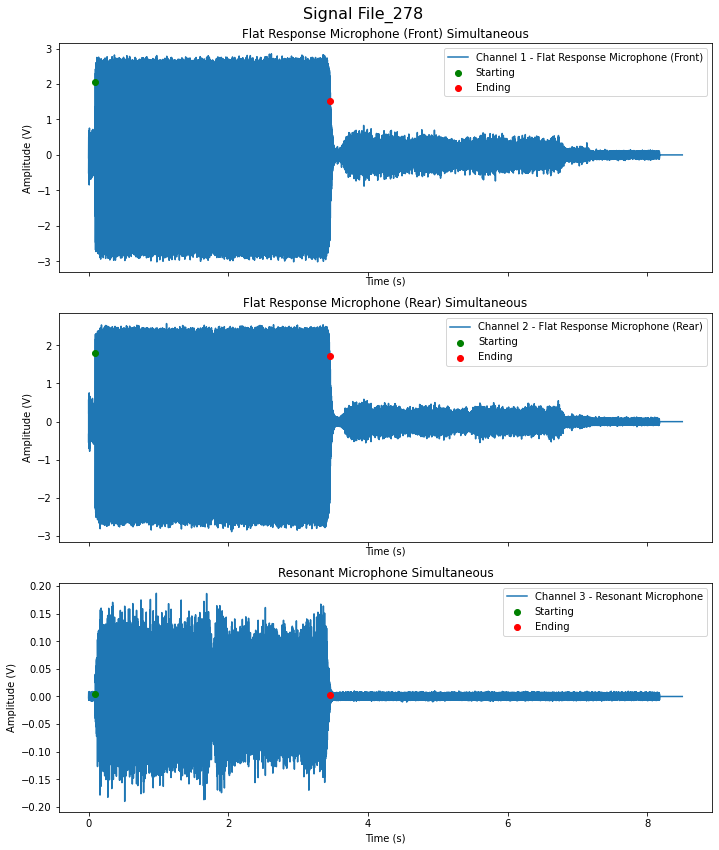

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_77, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_77.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 426344.50, Standard Deviation: 633.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_77.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 424734.50, Standard Deviation: 57.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_77.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424734.50, Standard Deviation: 57.50, Num. segments: 2
Plotting signals processed up to file number: File_77


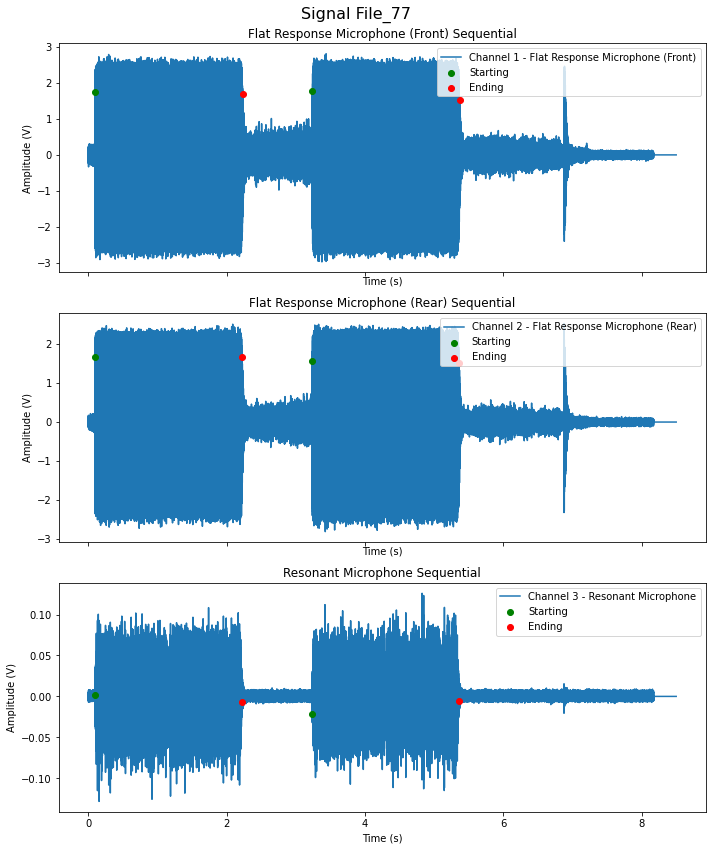

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_206, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_206.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672538.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_206.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671448.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_206.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671448.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals proc

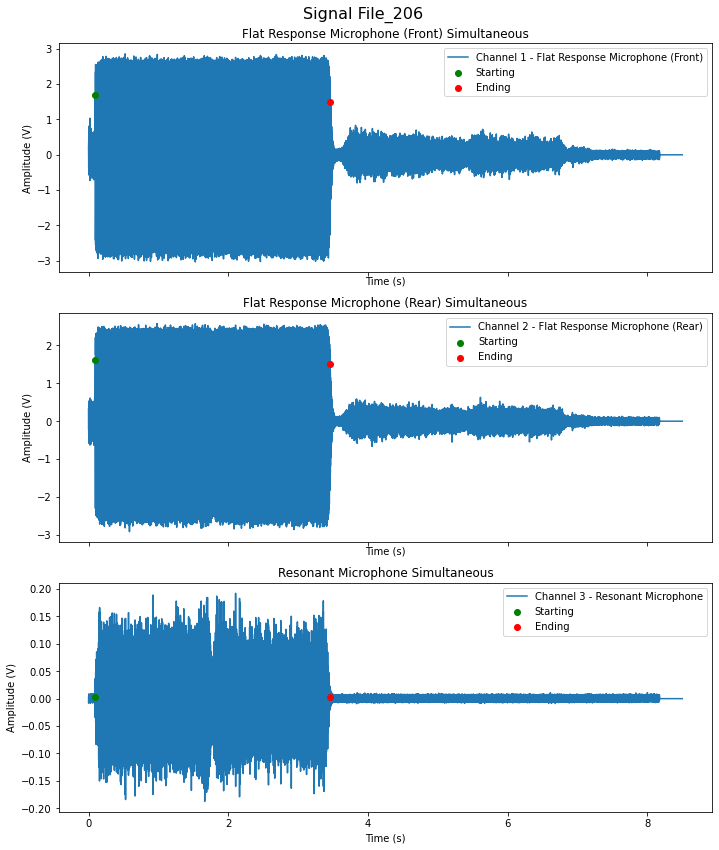

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_364, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_364.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673164.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_364.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 672042.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_364.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672042.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals process

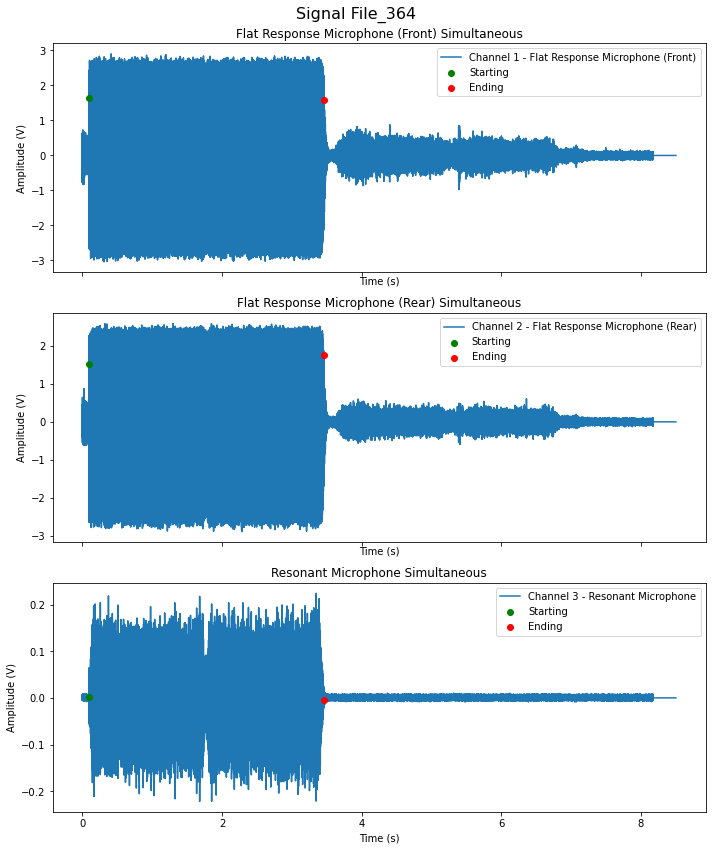

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_66, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_66.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 1 segments detected.
Average Segment Length: 487739.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_66.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 1 segments detected.
Average Segment Length: 486957.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_66.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 486957.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals processed up to file number: File_66


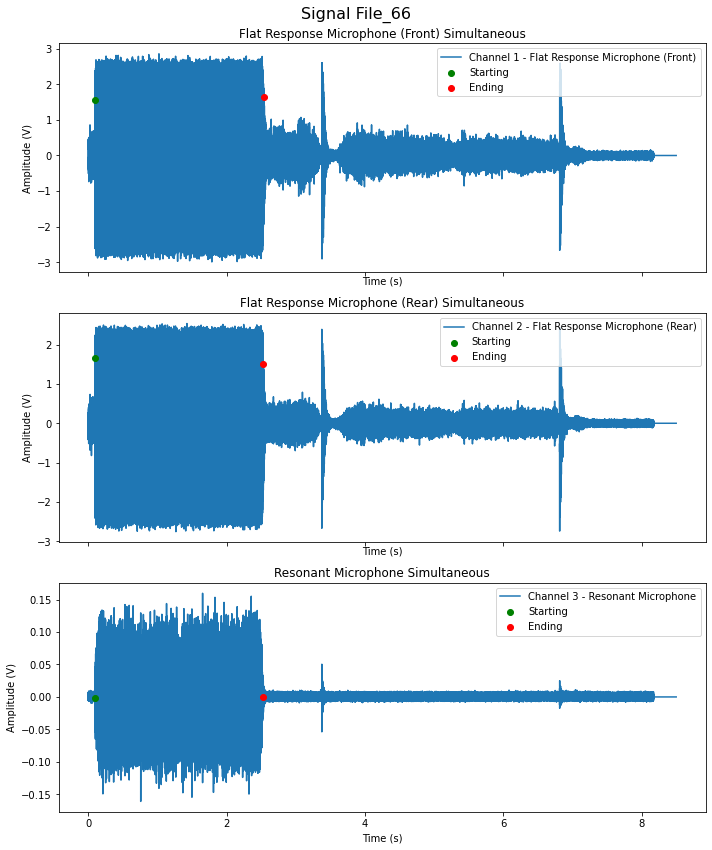

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_21, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_21.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 426410.00, Standard Deviation: 457.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_21.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 425257.50, Standard Deviation: 240.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_21.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425257.50, Standard Deviation: 240.50, Num. segments: 2
Plotting signals processed up to file number: File_21


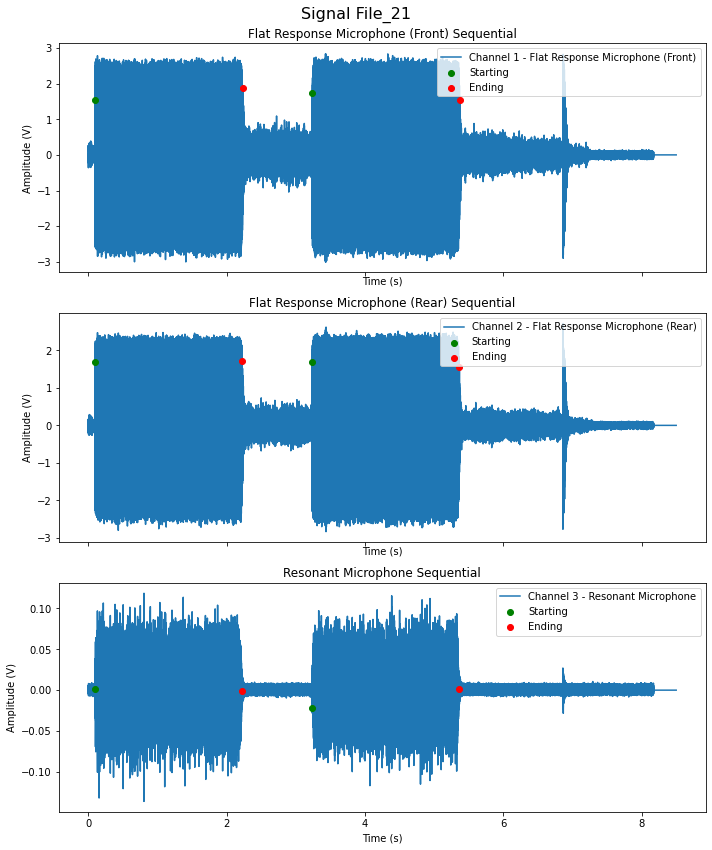

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_326, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_326.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672558.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_326.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671253.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_326.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671253.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals process

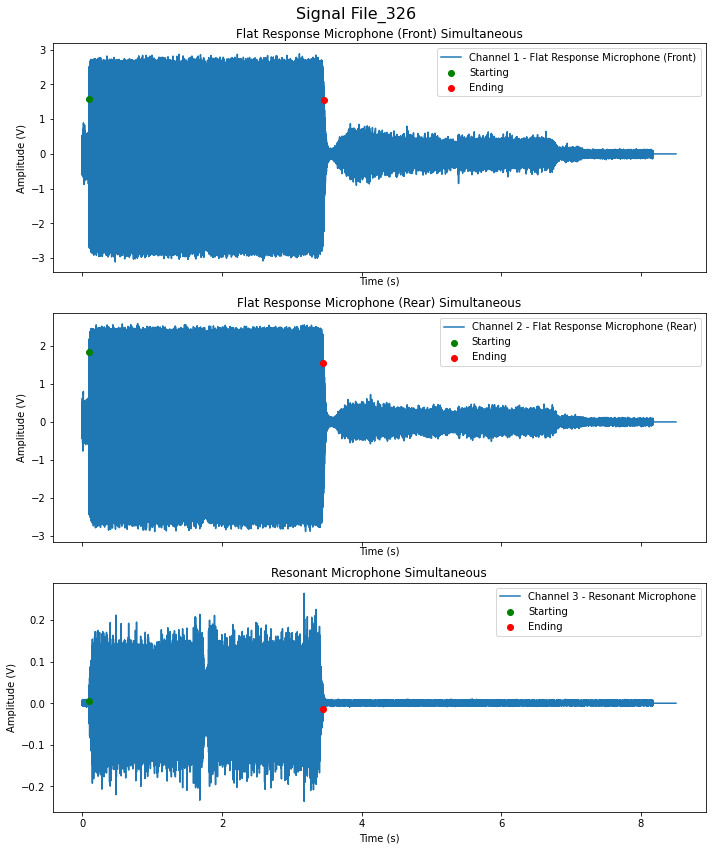

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_15, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_15.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 1 segments detected.
Average Segment Length: 429317.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_15.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 1 segments detected.
Average Segment Length: 427330.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_15.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427330.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals processed up to file number: File_15


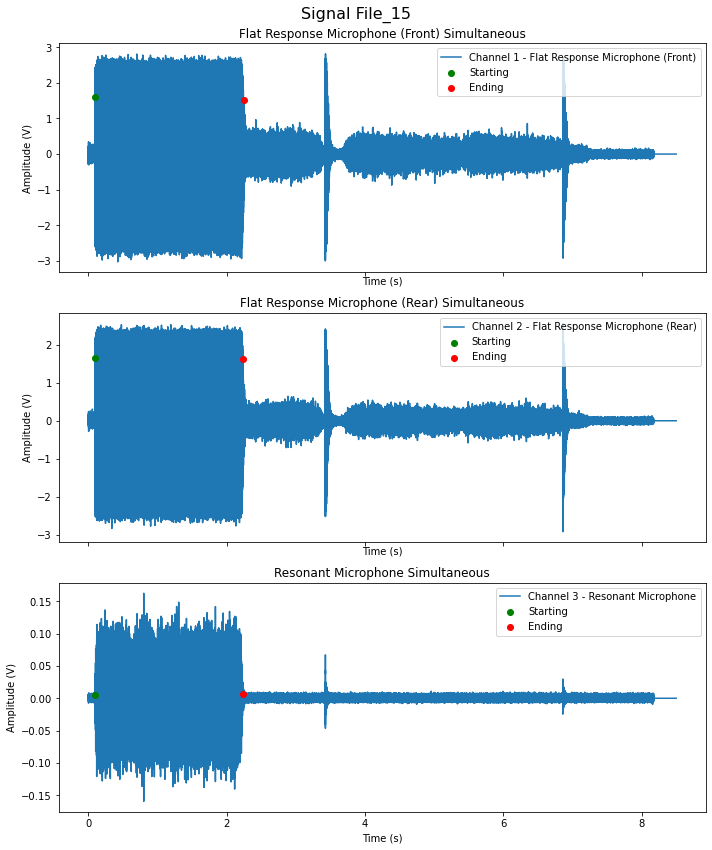

--------------------------------------------------------------------------------------------------------------------------------


In [8]:
data_path = './Raw_data/'

all_processed_data = parse_multimodal_signals_corrected_with_plotting(data_path, threshold=1.5)

['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_20, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_20.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 427336.50, Standard Deviation: 944.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_20.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 426147.50, Standard Deviation: 30.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_20.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426147.50, Standard Deviation: 30.50, Num. segments: 2
Plotting signals processed up to file number: File_20


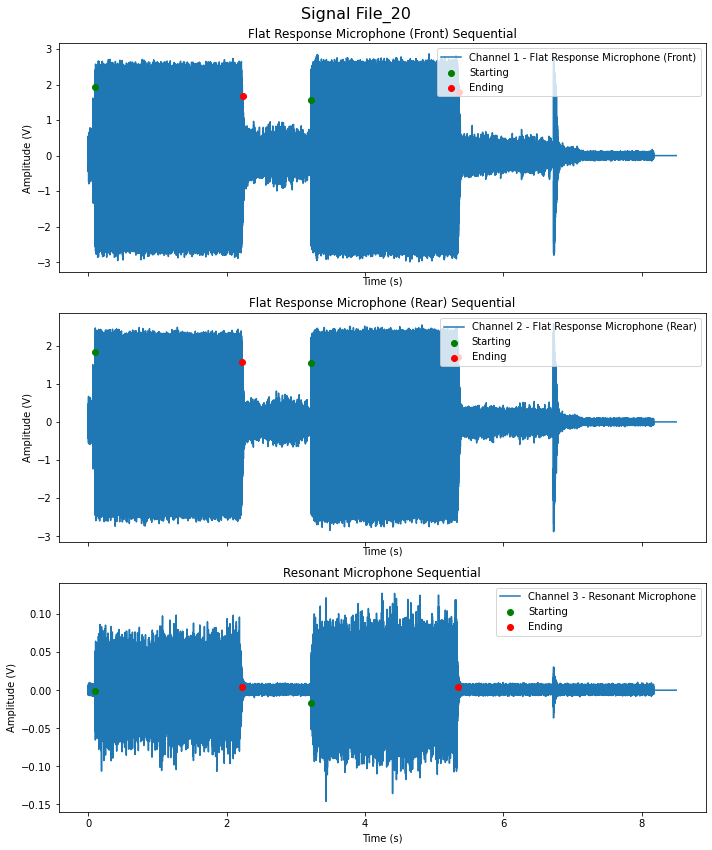

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_258, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_258.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526948.00, Standard Deviation: 143857.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_258.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 525043.50, Standard Deviation: 144604.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_258.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525043.50, Standard Deviation: 144604.50, Num. segments: 2
Plotting

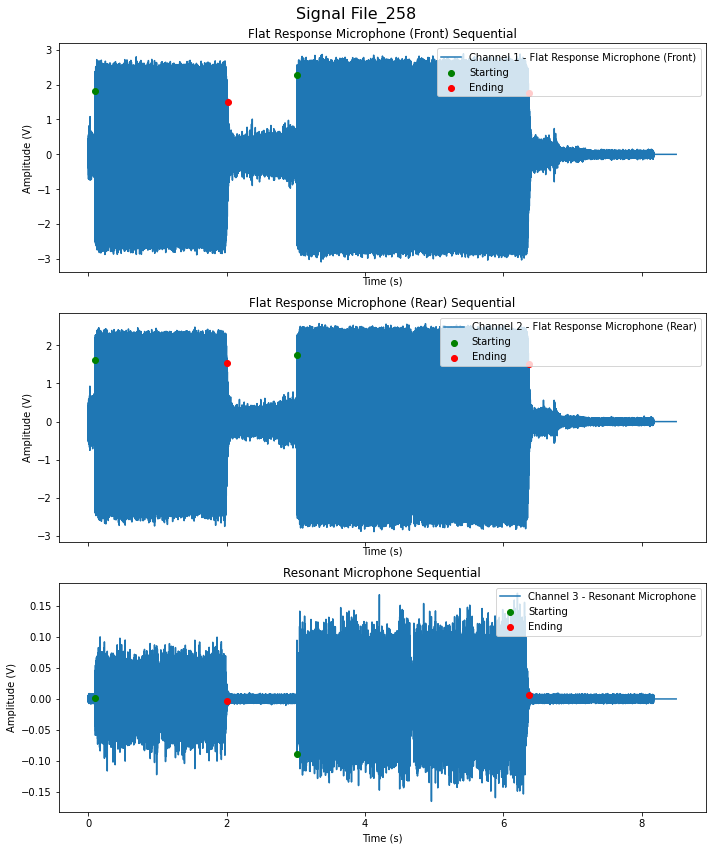

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_144, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_144.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 577089.50, Standard Deviation: 93660.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_144.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 575938.50, Standard Deviation: 93664.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_144.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575938.50, Standard Deviation: 93664.50, Num. segments: 2
Plotting signals processed up to file number: File_144


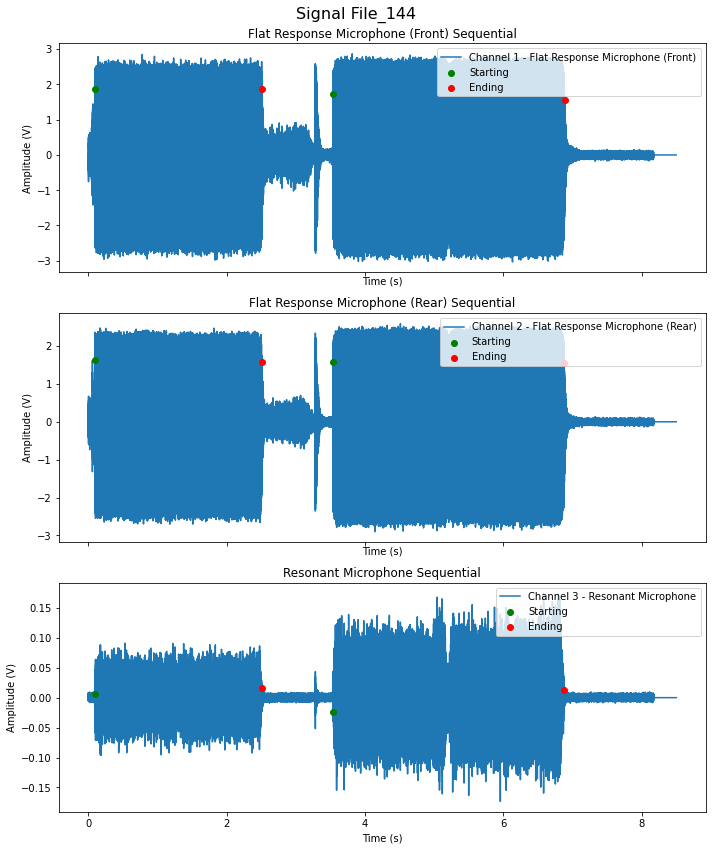

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_84, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_84.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 427025.00, Standard Deviation: 562.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_84.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 425471.00, Standard Deviation: 564.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_84.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425471.00, Standard Deviation: 564.00, Num. segments: 2
Plotting signals processed up to file number: File_84


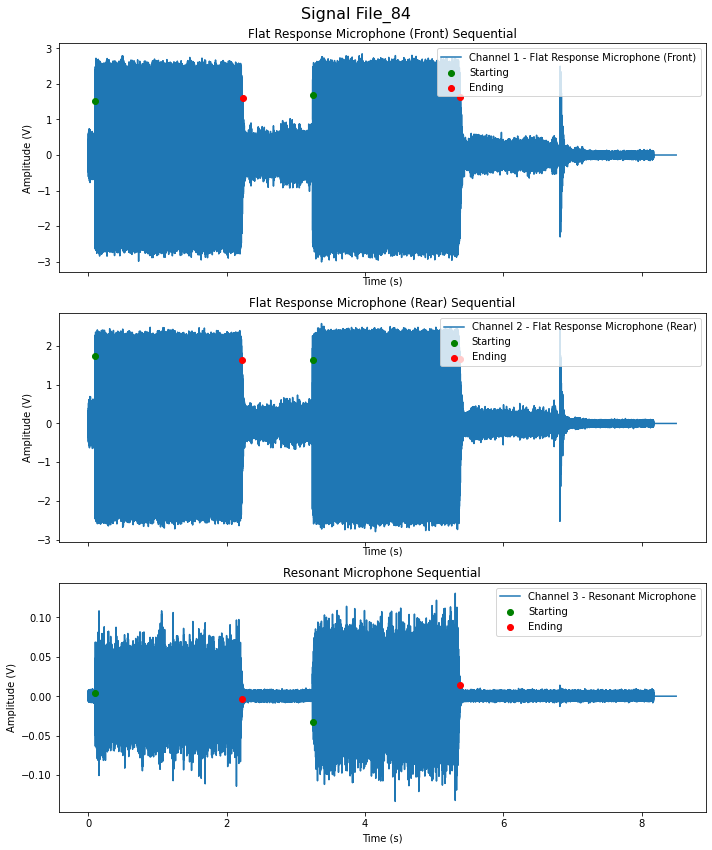

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_49, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_49.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 484534.50, Standard Deviation: 1075.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_49.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 483125.00, Standard Deviation: 0.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_49.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483125.00, Standard Deviation: 0.00, Num. segments: 2
Plotting signals processed up to file number: File_49


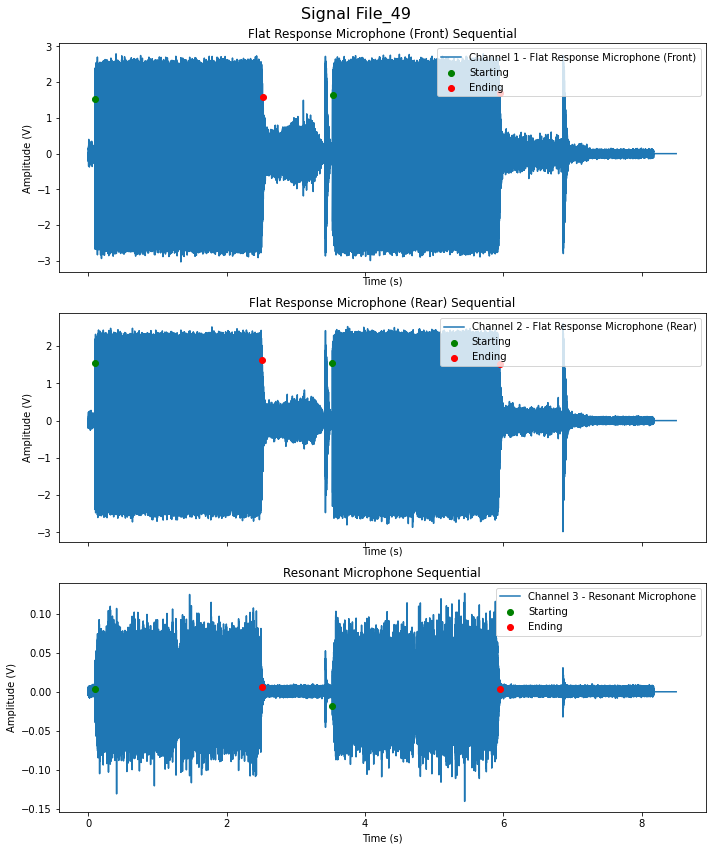

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_368, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_368.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673550.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_368.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671668.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_368.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671668.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals process

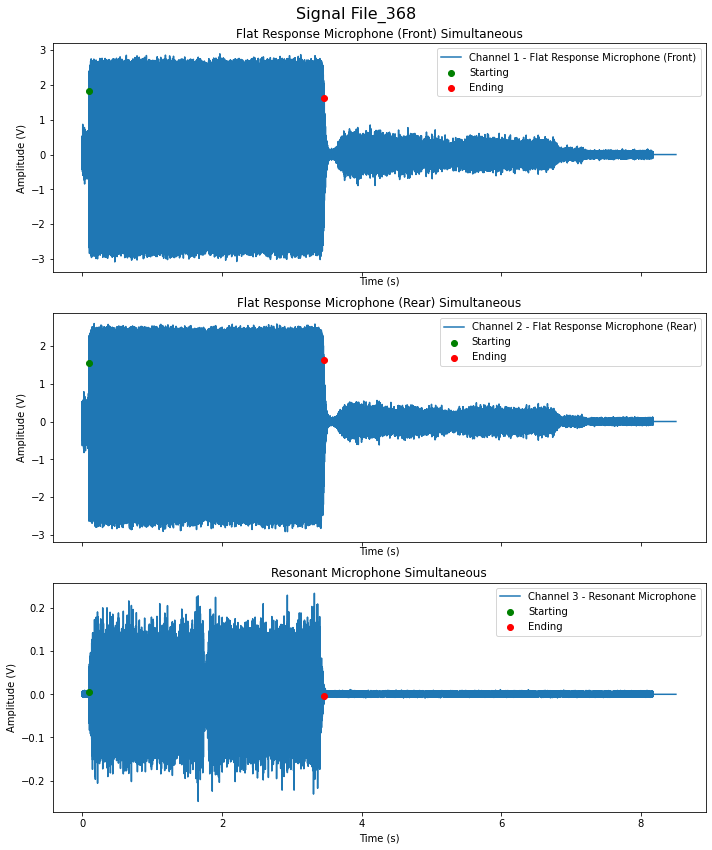

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_343, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_343.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671249.00, Standard Deviation: 780.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_343.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 669736.00, Standard Deviation: 955.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_343.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669736.00, Standard Deviation: 955.00, Num. segments: 2
Plotting signals pro

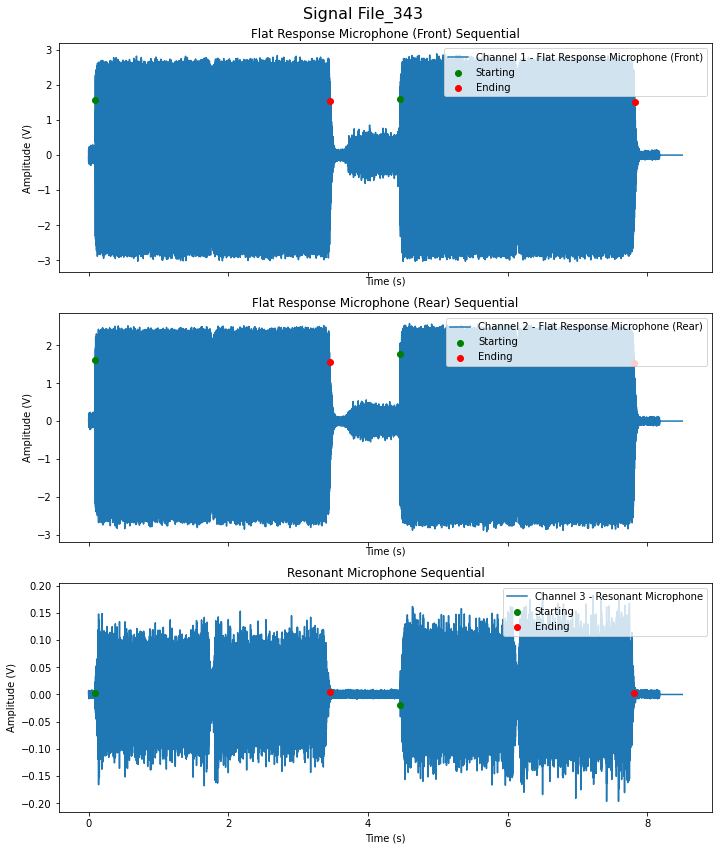

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_303, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_303.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671896.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_303.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670510.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_303.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670510.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals proc

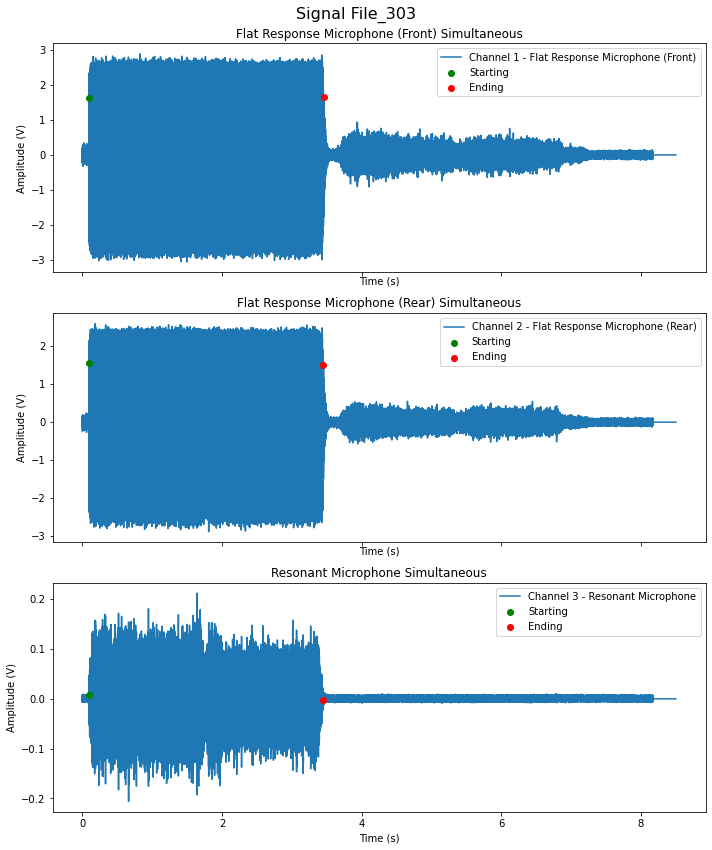

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_110, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_110.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 381976.00, Standard Deviation: 615.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_110.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 380856.50, Standard Deviation: 409.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_110.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380856.50, Standard Deviation: 409.50, Num. segments: 2
Plotting signa

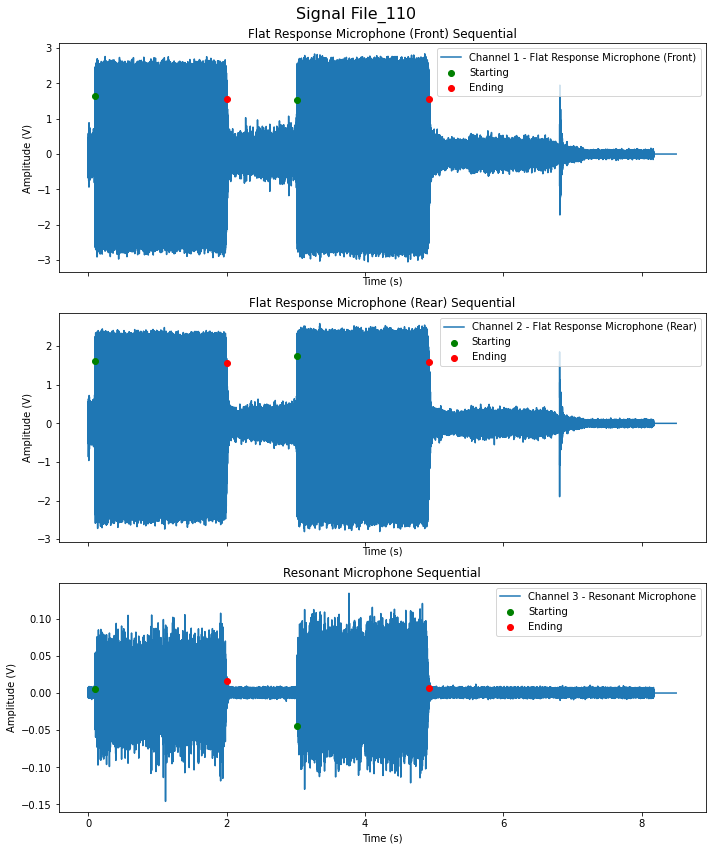

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_198, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_198.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548843.00, Standard Deviation: 121822.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_198.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 547224.00, Standard Deviation: 122083.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_198.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547224.00, Standard Deviation: 122083.00, Num. segments: 2
Plotting

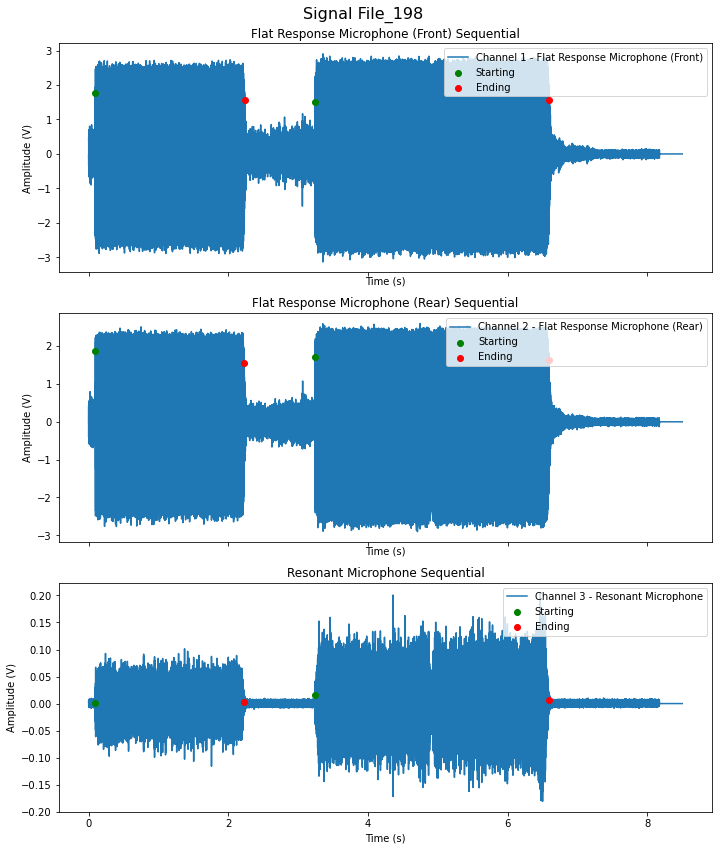

--------------------------------------------------------------------------------------------------------------------------------


In [9]:
all_processed_data = parse_multimodal_signals_corrected_with_plotting(data_path, threshold=1.5)

['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_332, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_332.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673170.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_332.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 672902.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_332.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672902.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals processed up to file number: File_332


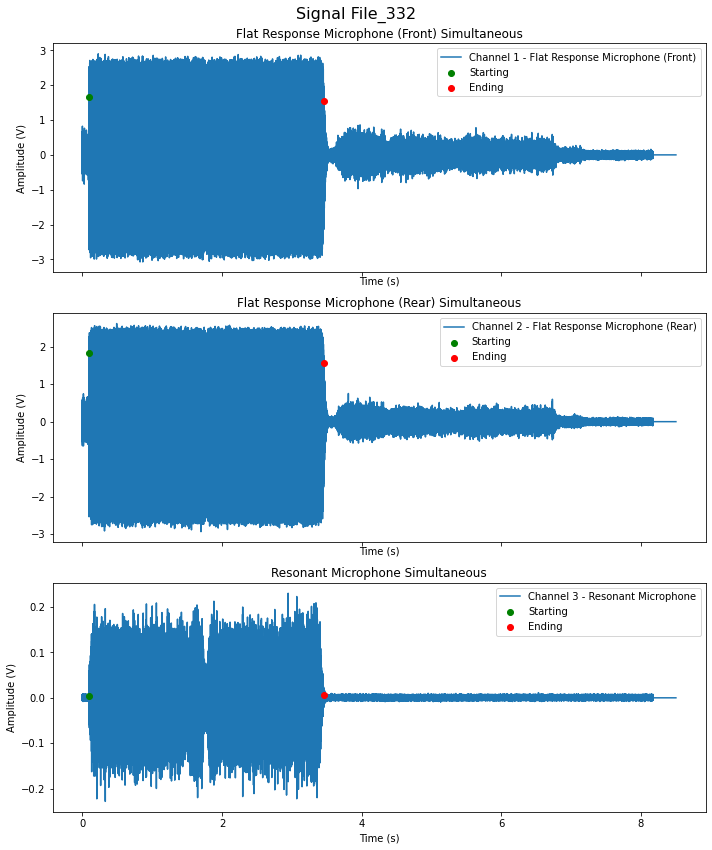

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_100, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_100.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 382617.50, Standard Deviation: 1350.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_100.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 381100.50, Standard Deviation: 421.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_100.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 381100.50, Standard Deviation: 421.50, Num. segments: 2
Plotting signals processed up to file number: File_100


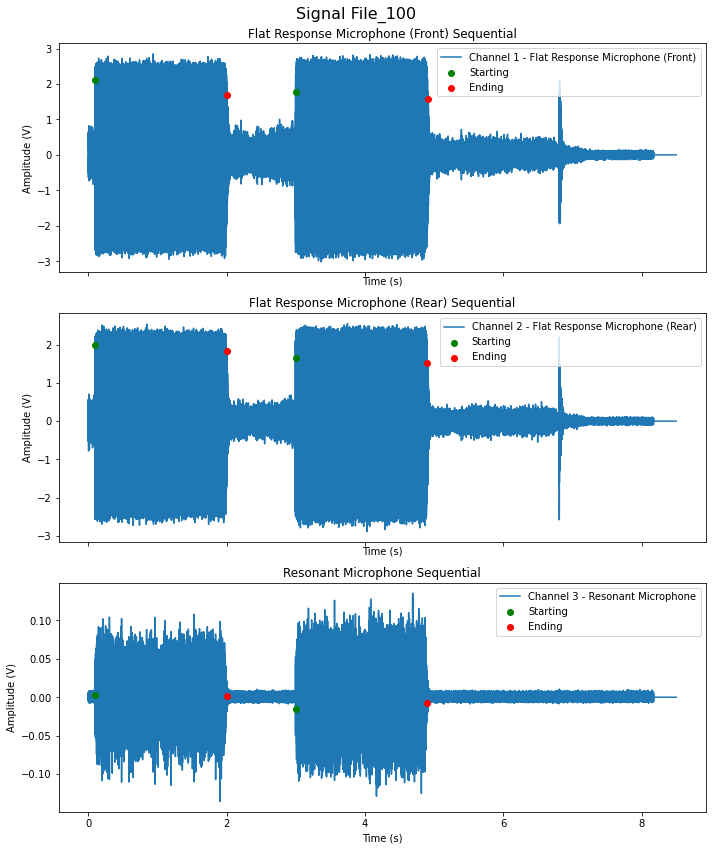

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_2, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_2.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 428337.50, Standard Deviation: 1164.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_2.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 427554.00, Standard Deviation: 150.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_2.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 427554.00, Standard Deviation: 150.00, Num. segments: 2
Plotting signals processed up to file number: File_2


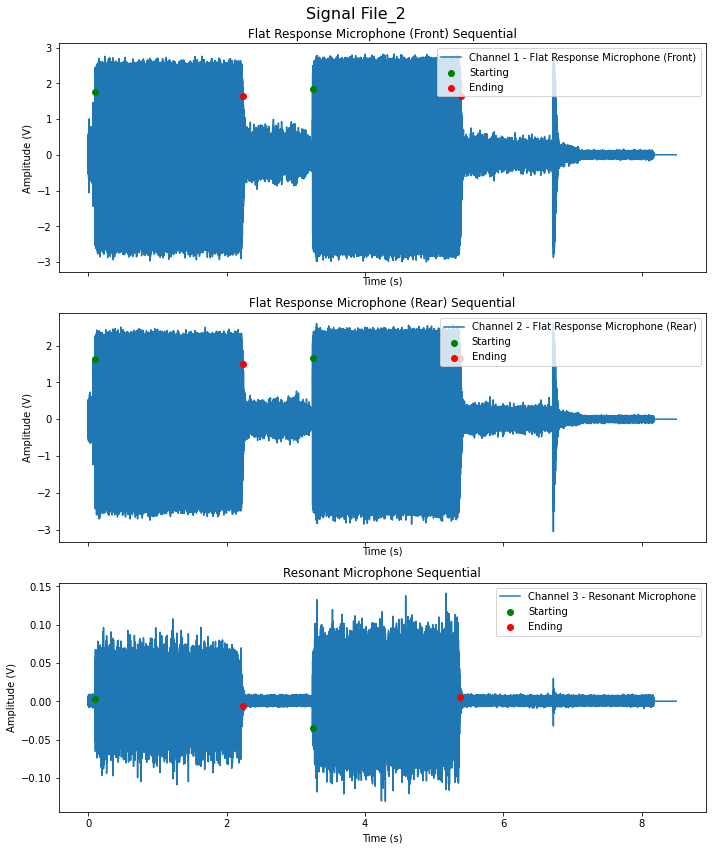

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_124, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_124.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 1 segments detected.
Average Segment Length: 384661.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_124.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 1 segments detected.
Average Segment Length: 384465.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_124.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 384465.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals processed up to file number: File_124


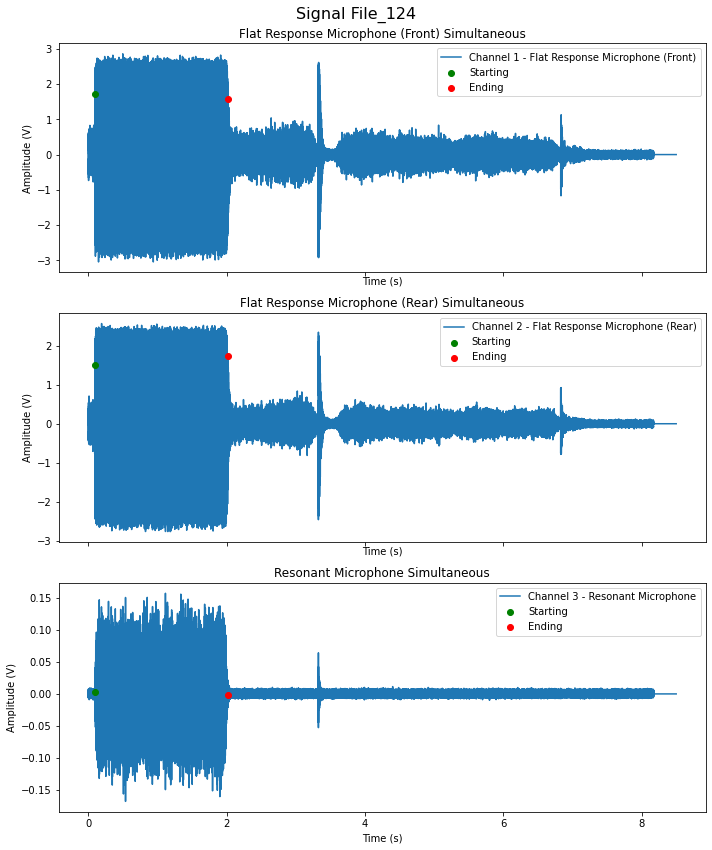

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_275, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_275.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673390.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_275.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671872.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_275.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671872.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals proc

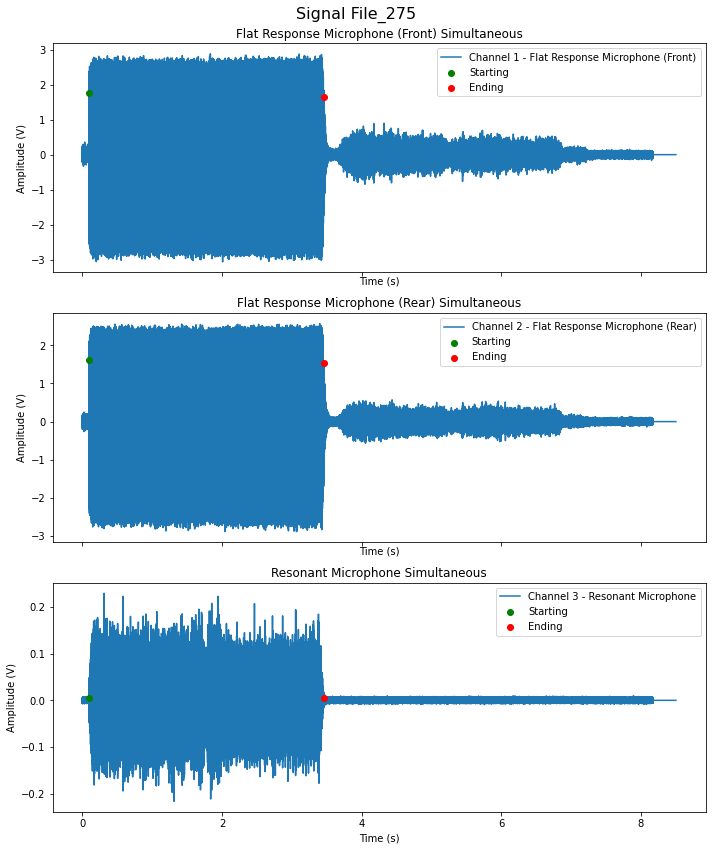

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_3, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_3.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 2 segments detected.
Average Segment Length: 427645.50, Standard Deviation: 297.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_3.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 2 segments detected.
Average Segment Length: 425758.00, Standard Deviation: 1.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_3.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425758.00, Standard Deviation: 1.00, Num. segments: 2
Plotting signals processed up to file number: File_3


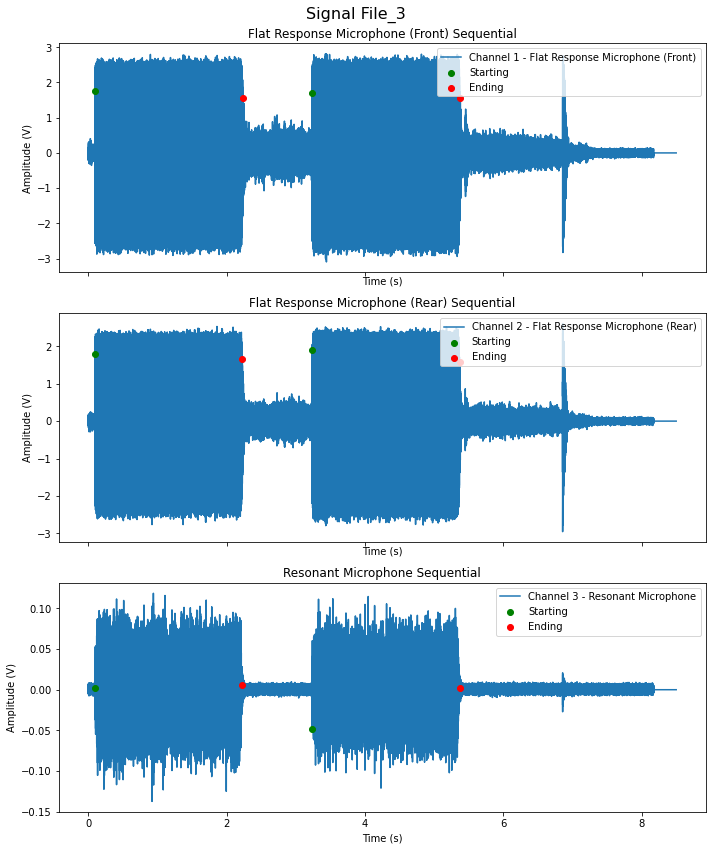

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_300, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_300.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671032.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_300.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 668934.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_300.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668934.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals proc

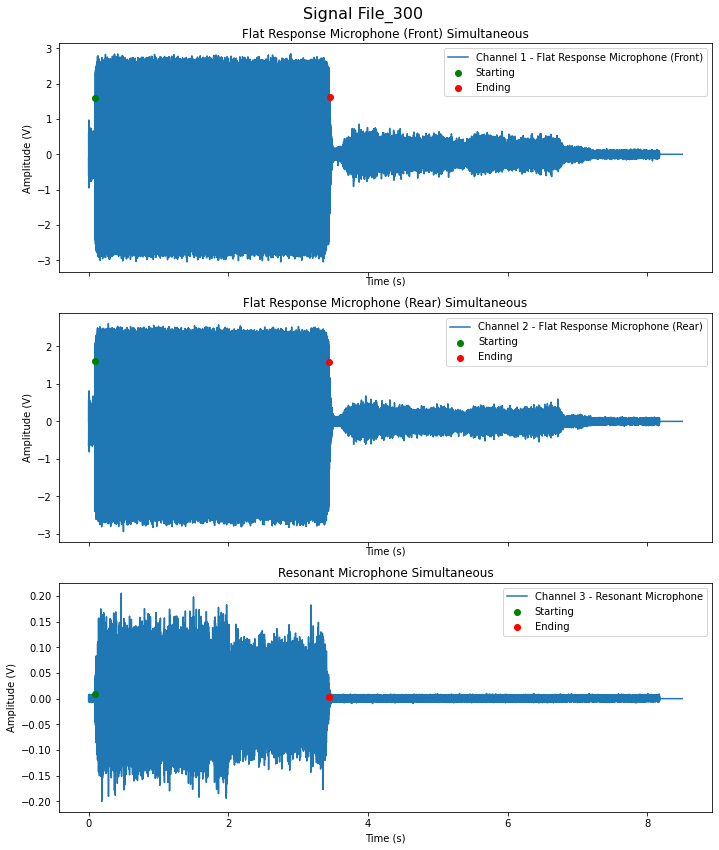

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_282, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_282.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526523.50, Standard Deviation: 143955.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_282.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 525440.00, Standard Deviation: 144536.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_282.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525440.00, Standard Deviation: 144536.00, Num. segments: 2
Plotting

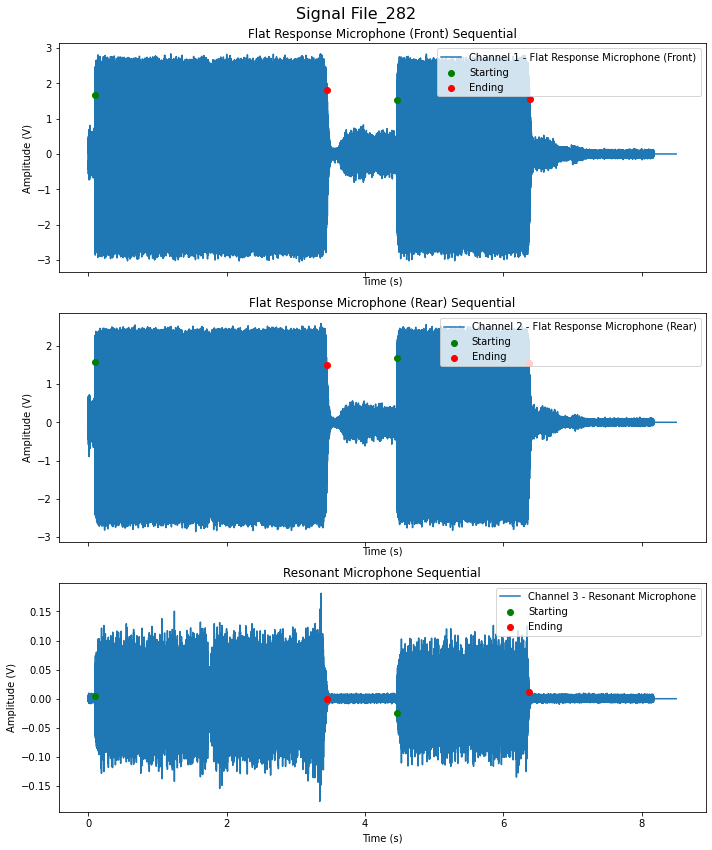

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_18, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_18.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 1 segments detected.
Average Segment Length: 432012.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_18.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 1 segments detected.
Average Segment Length: 429472.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_18.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429472.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals processed up to file number: File_18


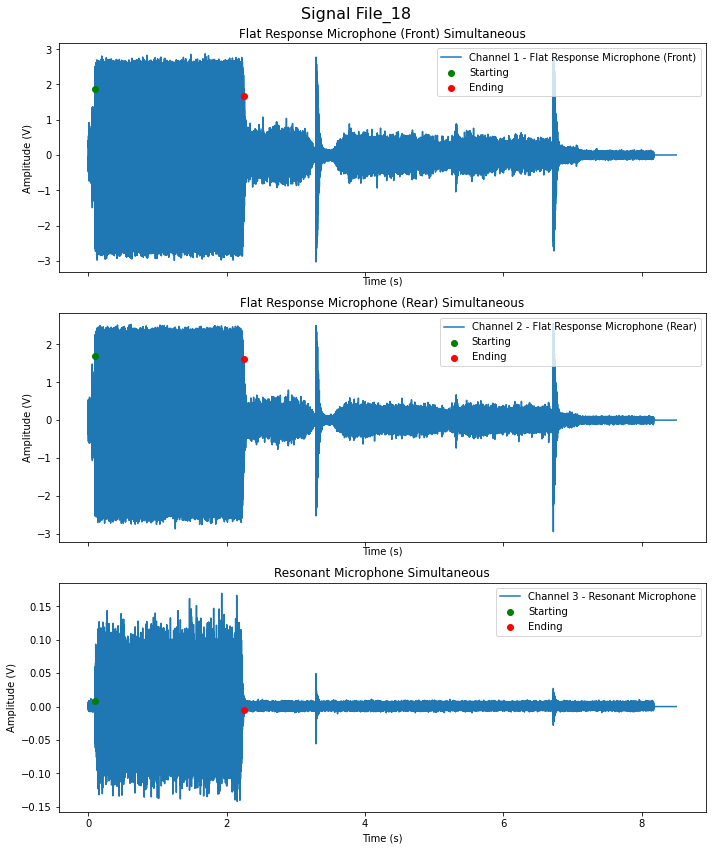

--------------------------------------------------------------------------------------------------------------------------------
['./Raw_data/channel_0/', './Raw_data/channel_1/', './Raw_data/channel_2/', './Raw_data/channel_3/']

Processing File: File_95, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_95.parquet for Channel 1


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 1: Processed with 1 segments detected.
Average Segment Length: 428404.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_95.parquet for Channel 2


/tmp/ipykernel_19269/1203117857.py:48: UserWarning: Warning: Excluded segment smaller than 10000 points.
  warnings.warn(f"Warning: Excluded segment smaller than {th} points.")


Channel 2: Processed with 1 segments detected.
Average Segment Length: 428057.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_95.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428057.00, Standard Deviation: 0.00, Num. segments: 1
Plotting signals processed up to file number: File_95


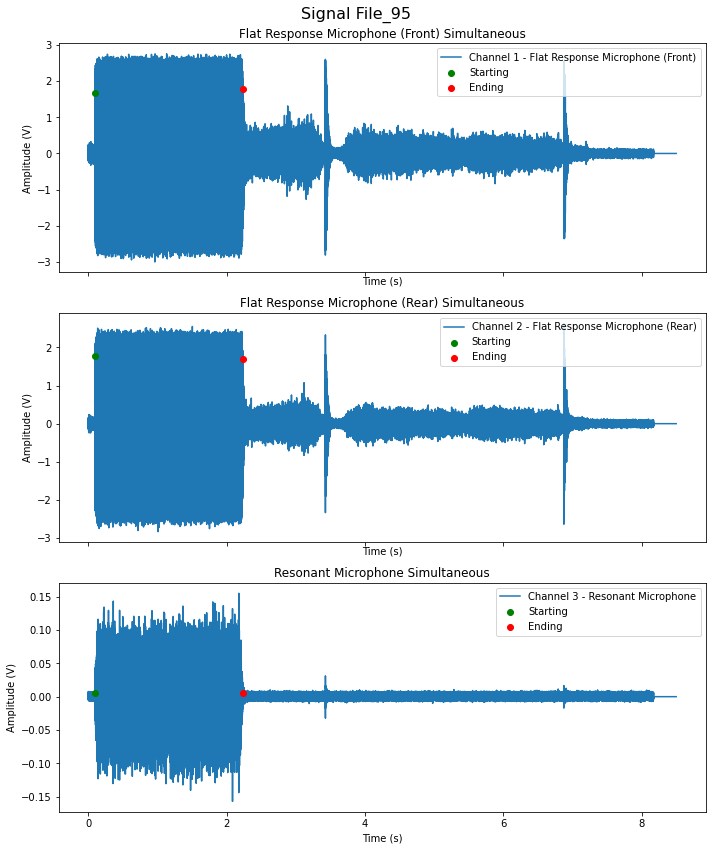

--------------------------------------------------------------------------------------------------------------------------------


In [10]:
all_processed_data = parse_multimodal_signals_corrected_with_plotting(data_path, threshold=1.5)